# 安隆詐騙案 詐欺犯識別機器學習模型


[嫌疑犯標籤]
1. poi : 是否是嫌疑人 (True=POI, Flase=Non-POI)

[郵件相關]
2. email_address
3. to_messages            : 發送郵件的數量
4. from_messages          : 收到郵件的數量
5. from_poi_to_this_person: 收到來自POI 的郵件數量
6. from_this_person_to_poi: 發送給POI的郵件數量
7. shared_receipt_with_poi: 收到來自POI抄送郵件的數量

[財物相關]
8. salary                    : 工資
9. bonus                     : 獎金
10. long_term_incentive      : 長期激勵報酬
11. deferred_income          : 延期收入
12. deferral_payments        : 延期薪資
13. loan_advances            : 預支貸款
14. other
15. expenses                 : 開支
16. director_fees            : 董事費
17. total_payments           : 總薪資與獎金
18. exercised_stock_options  : 已使用的股票期權
19. restricted_stock         : 受限股票
20. restricted_stock_deferred: 延期的受限股票
21. total_stock_value        : 總股票價值

有關資料集中財務資料欄位的特徵: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (單位皆為美元)。

有關 email 的特徵: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (除了 email_address，其餘皆為次數)

因此，財務資料得資料應該都是連續型的數字資料，email 通訊的資料欄位應該都是離散型的數字資料。


In [1]:
#載入分析套件及資料集
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#解決分類樣本數量不平衡的狀況的套件
from imblearn.over_sampling import SMOTE 

In [2]:
#建立資料清理函數

def DataClean(df_temp):
    num_col = ['salary', 'deferral_payments', 'total_payments', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
    count_col = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] 
    
    df_clean=df_temp.copy()
    #數字型欄位， 遺失值用欄位平均數來補 
    for col in num_col:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode())
        df_clean[col] = df_clean[col].abs()  

    #記數值欄都是郵件往來次數，所以遺失值補 0 比較合理
    for col in count_col:
        df_clean[col] = df_clean[col].fillna(0)
        df_clean[col] = df_clean[col].abs()  
    
    df_clean['name'] = LabelEncoder().fit_transform(df_clean['name'])
       
    return df_clean

#建立特徵工程函數
def Feature_eng(df_temp):    
    df_FE = df_temp.copy()
    
    ''' 
    新增特徵值
    total_asset = 總薪資及獎金 + 總股票價值
    total_communication = 收到來自POI 的郵件數量 + 發送給POI的郵件數量
    '''

    df_FE['total_asset'] = df_FE['total_payments'] + df_FE['total_stock_value']
    df_FE['total_communication'] = df_FE['from_poi_to_this_person'] + df_FE['from_this_person_to_poi']
    
    df_FE = df_FE.fillna(0)
   
    return df_FE

In [3]:
#讀取資料集
df = pd.read_csv('train_data.csv')
train_Y = df['poi']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 22 columns):
name                         113 non-null object
bonus                        61 non-null float64
deferral_payments            28 non-null float64
deferred_income              34 non-null float64
director_fees                13 non-null float64
email_address                83 non-null object
exercised_stock_options      81 non-null float64
expenses                     73 non-null float64
from_messages                65 non-null float64
from_poi_to_this_person      65 non-null float64
from_this_person_to_poi      65 non-null float64
loan_advances                2 non-null float64
long_term_incentive          49 non-null float64
other                        69 non-null float64
poi                          113 non-null bool
restricted_stock             82 non-null float64
restricted_stock_deferred    10 non-null float64
salary                       73 non-null float64
shared_receipt_wi

### 資料集中共有22個欄位，其他欄位都或多或少有缺值。 

In [4]:
#email address 欄位沒有特別意義先拿掉， loan_advances 欄位缺失值太多，不具代表意義，所以也移除，poi 是分類標籤所以也拿掉
df= df.drop(['poi','email_address','loan_advances'],axis=1)

In [5]:
#對訓練資料集做資料清理及特徵工程
df_train = DataClean(df)
df_train = Feature_eng(df_train)
df_train.describe()

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,total_asset,total_communication
count,113.00000,1.130000e+02,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,113.000000,113.000000,...,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,1.130000e+02,1.130000e+02,1.130000e+02,113.000000
mean,56.00000,6.194126e+05,3.033747e+05,1.391793e+05,20569.415929,2.139748e+06,32973.097345,409.168142,37.274336,23.061947,...,3.286061e+05,9.396291e+05,40832.619469,2.376472e+05,639.283186,1240.212389,2.416590e+06,3.059712e+06,5.379631e+06,60.336283
std,32.76431,1.242456e+06,6.766507e+05,4.883707e+05,42321.857381,5.251192e+06,45358.746287,1607.452015,76.533402,70.089392,...,1.076375e+06,2.202460e+06,117796.853724,1.965296e+05,1039.799616,2379.796707,9.784445e+06,6.791577e+06,1.519515e+07,132.743214
min,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,28.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.760000e+02,0.000000e+00,0.000000,1.584030e+05,0.000000,0.000000,2.497870e+05,2.211410e+05,1.015896e+06,0.000000
50%,56.00000,2.500000e+05,0.000000e+00,0.000000e+00,0.000000,4.934890e+05,16514.000000,16.000000,0.000000,0.000000,...,2.856000e+03,3.605280e+05,0.000000,2.473380e+05,71.000000,232.000000,1.099100e+06,8.802900e+05,2.217774e+06,4.000000
75%,84.00000,7.500000e+05,1.819930e+05,2.500000e+04,0.000000,1.624396e+06,50080.000000,59.000000,37.000000,11.000000,...,2.774640e+05,6.982420e+05,0.000000,2.885420e+05,742.000000,1433.000000,1.934359e+06,2.072035e+06,4.618918e+06,50.000000
max,112.00000,8.000000e+06,2.964506e+06,3.504386e+06,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,411.000000,...,1.035973e+07,1.476169e+07,560222.000000,1.111258e+06,4527.000000,15149.000000,1.035598e+08,4.911008e+07,1.526699e+08,939.000000


In [6]:
df_train.head()

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,total_asset,total_communication
0,84,1750000.0,102500.0,3504386.0,3285.0,19794175.0,46950.0,18.0,42.0,4.0,...,174839.0,2748364.0,560222.0,420636.0,864.0,905.0,505050.0,22542539.0,23047589.0,46.0
1,92,5600000.0,7961.0,0.0,17500.0,19250000.0,29336.0,108.0,88.0,30.0,...,22122.0,6843672.0,472568.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0,34776388.0,118.0
2,91,200000.0,10259.0,4167.0,36666.0,1624396.0,22884.0,39.0,13.0,14.0,...,1573324.0,869220.0,409554.0,211844.0,91.0,225.0,2003885.0,2493616.0,4497501.0,27.0
3,58,800000.0,16586.0,0.0,101250.0,0.0,118134.0,0.0,0.0,0.0,...,907502.0,985032.0,329825.0,224305.0,0.0,0.0,2652612.0,985032.0,3637644.0,0.0
4,15,1250000.0,27610.0,262500.0,102492.0,0.0,35818.0,144.0,199.0,25.0,...,486.0,126027.0,153686.0,240189.0,2188.0,2598.0,1639297.0,126027.0,1765324.0,224.0


### 資料前處理後，訓練資料集總共有21個特徵欄位

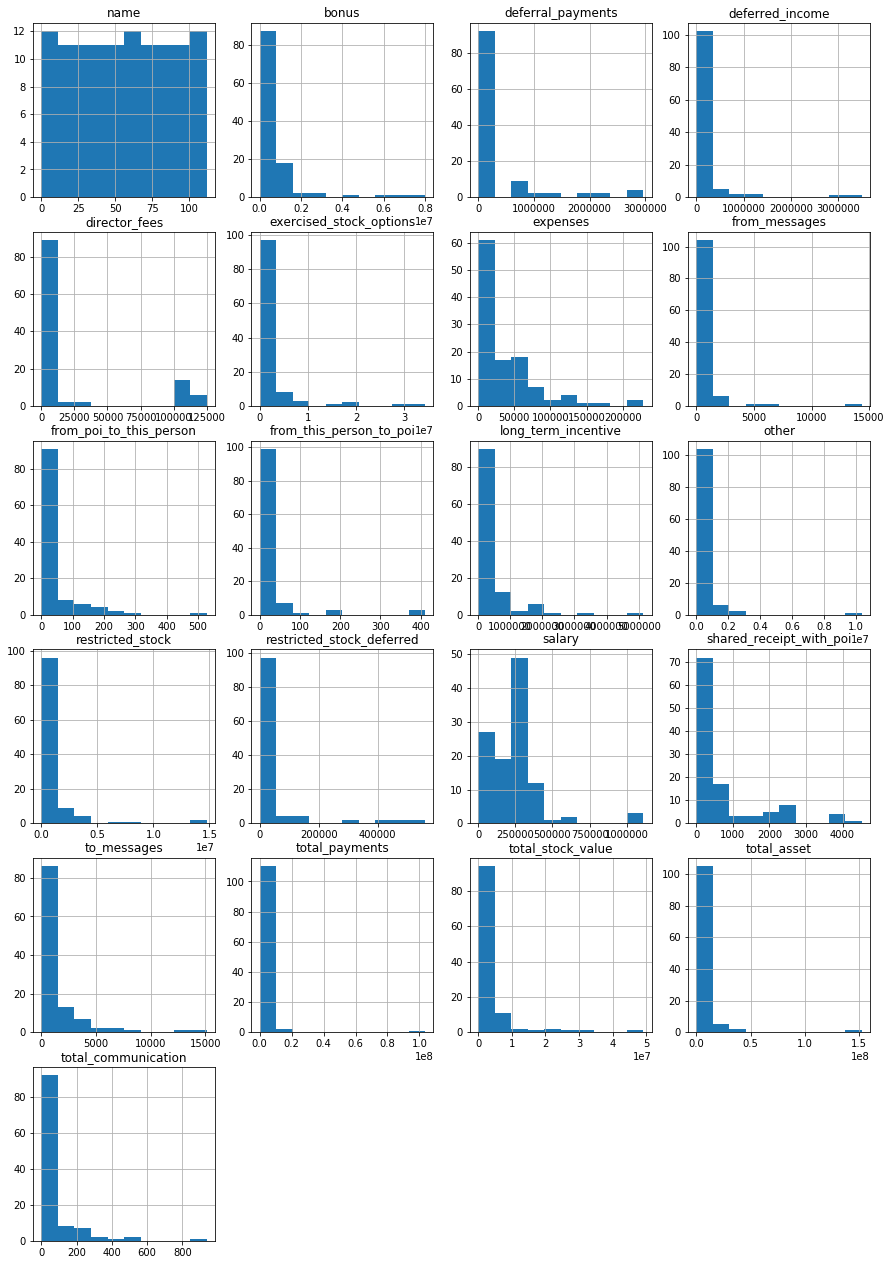

In [7]:
#將訓練資料集的每個特徵值畫出值發圖看資料分布
fig_cols = 4
fig_rows = len(df_train.columns)

plt.figure(figsize=(15,80))
for i,col in enumerate (df_train.columns):
    plt.subplot(fig_rows,fig_cols,i+1)
    df_train[col].hist()
    plt.title(str(col))
plt.show()

### 經過資料清理及特徵工程之後，從直方圖中顯示各項特徵都呈現很嚴重的偏態。因為大部分的員工都應該是守法的人，所以詐欺案的嫌疑人反而應該算是一種的異常值，因此正常的模型是要排除資料異常值，但是在這裡反而應該是要凸顯異常值以利分類模型去做判斷。所以資料清理的過程中針對異常值不做排除的動作，也特別選用要凸顯異常值的方式來填補缺失值

The POI are 13 , The Non-POI are 100


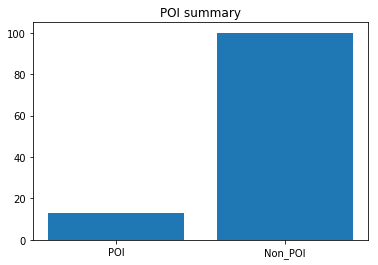

In [8]:
#顯示訓練資料集中 POI 的數量 
POI_num = [len(train_Y[train_Y==True]),len(train_Y[train_Y==False])]
print(f'The POI are {POI_num[0]} , The Non-POI are {POI_num[1]}')
plt.title('POI summary')
plt.bar(['POI', 'Non_POI'],POI_num);

### 原始訓練資料集中的嫌疑人有 13人，非嫌疑人有 100人。
### 分類標籤的比例呈現不平衡的狀態，為使分割後的訓練資料集及測試資料集在POI的比例上能達到1:1的狀態，以利訓練模型時不會特別偏重在非嫌疑人的類別，因此需要透過人工合成樣本的方式來增加嫌疑人類別的特徵資料

In [9]:
#將訓練資料集透過 SMOTE 技術，將不平衡的 POI Label 調整為 True :Fales = 1:1  
sm = SMOTE(random_state=4)
train_data_res,train_Y_res = sm.fit_sample(df_train, train_Y.ravel())
train_data_res = pd.DataFrame(train_data_res,columns=df_train.columns)

### 開始訓練模型及驗證模型績效

In [10]:
#建立梯度提升機
GBclf = GradientBoostingClassifier()

#特徵選擇
GBclf.fit(train_data_res, train_Y_res)
feats = pd.Series(data=GBclf.feature_importances_, index=train_data_res.columns)
feats = feats.sort_values(ascending=False)
feats

director_fees                7.699116e-01
total_asset                  2.300884e-01
restricted_stock_deferred    9.225829e-08
total_communication          0.000000e+00
from_poi_to_this_person      0.000000e+00
bonus                        0.000000e+00
deferral_payments            0.000000e+00
deferred_income              0.000000e+00
exercised_stock_options      0.000000e+00
expenses                     0.000000e+00
from_messages                0.000000e+00
long_term_incentive          0.000000e+00
from_this_person_to_poi      0.000000e+00
other                        0.000000e+00
restricted_stock             0.000000e+00
salary                       0.000000e+00
shared_receipt_with_poi      0.000000e+00
to_messages                  0.000000e+00
total_payments               0.000000e+00
total_stock_value            0.000000e+00
name                         0.000000e+00
dtype: float64

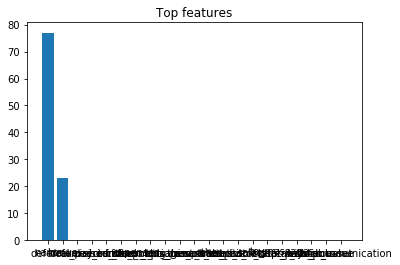

In [74]:
plt.title('Top features')
plt.bar(train_data_res.columns,feats*100)
plt.show()

### 經梯度提升樹的特徵選擇，前三項特徵已經呈現很明顯的重要性，但保險起見保留一點其他特徵的影響，故選用前五項特徵值來訓練模型。原本的訓練資料集有 21 個欄位，最後降維剩用五個特徵值來建立分類模型即可。

In [45]:
#分割訓練資料集及驗證資料集
topfeatures = list(feats[:5].index)
x_train, x_test, y_train, y_test = train_test_split(train_data_res[topfeatures],train_Y_res,
                                                    test_size=0.25, random_state=4)

In [46]:
#先交叉驗證一下模型分數
print(f'Gradient Boosting Clf Score : {cross_val_score(GBclf, x_train, y_train, cv=7).mean()}')

Gradient Boosting Clf Score : 0.9931972789115646


In [47]:
#開始訓練模型及驗證模型能力
GBclf.fit(x_train, y_train)
y_pred = GBclf.predict(x_test)

print(f'Acc score : {GBclf.score(x_test,y_test)} \n')
print(metrics.classification_report(y_test, y_pred))

Acc score : 1.0 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        23
        True       1.00      1.00      1.00        27

   micro avg       1.00      1.00      1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



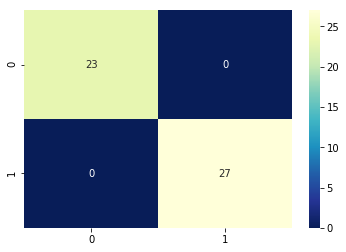

In [48]:
#使用混淆矩陣驗證分類的正確率
confmat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confmat, cmap='YlGnBu_r', annot=True, fmt='d');

### 用預設參數來建立的模型，各項評估指標已呈現極高的辨識率。可見前五項特徵值應是足夠了。

In [49]:
# 設定要訓練的超參數組合
n_estimators = [50 ,100, 150, 200, 250, 500]
max_depth = [1,3, 5, 7, 9, 11]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

#建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(GBclf, param_grid, scoring='accuracy', n_jobs=-1,cv=7,iid =True)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)
print(f'Best Accuracy: {grid_result.best_score_} using {grid_result.best_params_}')

Best Accuracy: 0.9933333333333333 using {'max_depth': 1, 'n_estimators': 100}


In [50]:
# 使用最佳參數重新建立模型
clf_bestparam = GradientBoostingClassifier(max_depth = grid_result.best_params_['max_depth'],
                                           n_estimators = grid_result.best_params_['n_estimators'],random_state = 4)
# 訓練模型
clf_bestparam.fit(x_train, y_train)

# 預測測試集
y_pred = clf_bestparam.predict(x_test)

print(f'Acuuracy of Best Param: {clf_bestparam.score(x_test,y_test)} \n')
print(metrics.classification_report(y_test, y_pred))

Acuuracy of Best Param: 1.0 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        23
        True       1.00      1.00      1.00        27

   micro avg       1.00      1.00      1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



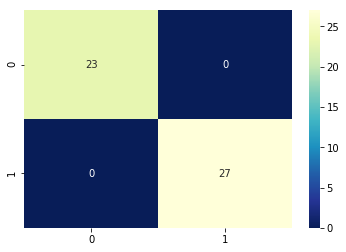

In [51]:
#使用混淆矩陣驗證分類的正確率
confmat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confmat, cmap='YlGnBu_r', annot=True, fmt='d');

### 經網格搜尋最佳的超參數之後，經過調整後的模型，辨識率也是極接近100%


### 將測試資料集套入訓練好的模型進行最終預測

In [52]:
#使用測試資料集套入模型進行最後預測
df1 = pd.read_csv('test_features.csv')
df1 = df1.drop(['email_address','loan_advances'],axis=1)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 19 columns):
name                         33 non-null object
bonus                        21 non-null float64
deferral_payments            11 non-null float64
deferred_income              15 non-null float64
director_fees                4 non-null float64
exercised_stock_options      21 non-null float64
expenses                     22 non-null float64
from_messages                21 non-null float64
from_poi_to_this_person      21 non-null float64
from_this_person_to_poi      21 non-null float64
long_term_incentive          17 non-null float64
other                        24 non-null float64
restricted_stock             28 non-null float64
restricted_stock_deferred    8 non-null float64
salary                       22 non-null float64
shared_receipt_with_poi      21 non-null float64
to_messages                  21 non-null float64
total_payments               29 non-null float64
total_stock_value 

In [53]:
#針對各欄位的遺失值做資料清理及特徵工程
df_test = DataClean(df1)
df_test = Feature_eng(df_test)

In [54]:
#最後將測試資料集套入模型預測
y_pred = clf_bestparam.predict_proba(df_test[topfeatures]) 
POI_P = pd.DataFrame(y_pred)

In [55]:
#輸出測試資料集的預測結果
submit = pd.DataFrame(df1['name'],columns=['name'])
submit['poi'] = POI_P[0]
submit

,name,poi
0,BELDEN TIMOTHY N,0.010660
1,BOWEN JR RAYMOND M,0.010660
2,HANNON KEVIN P,0.010660
3,DELAINEY DAVID W,0.010660
4,CAUSEY RICHARD A,0.989130
5,HICKERSON GARY J,0.989130
6,FREVERT MARK A,0.989130
7,CHAN RONNIE,0.025610
8,DONAHUE JR JEFFREY M,0.989130
9,REYNOLDS LAWRENCE,0.989130


In [56]:
#輸出預測的嫌疑人數量及名單
POI_num =len(submit[submit['poi'] < 0.1]['name'])
print(f'{len(df1)} 筆的資料中有 {POI_num} 個詐欺嫌疑人!')
print(f'{POI_num} 個嫌疑人的姓名是 :\n')      
print(submit[submit['poi'] < 0.1]['name'])

33 筆的資料中有 8 個詐欺嫌疑人!
8 個嫌疑人的姓名是 :

0       BELDEN TIMOTHY N
1     BOWEN JR RAYMOND M
2         HANNON KEVIN P
3       DELAINEY DAVID W
7            CHAN RONNIE
13        MEYER JEROME J
20                 TOTAL
26      BHATNAGAR SANJAY
Name: name, dtype: object


In [57]:
#將嫌疑人預測結果輸出成 csv 檔案
submit.to_csv('Enron Fraund predict.csv',index = False)

## 實際上傳Kaggle 後的得分及排名，預測結果的準確度最高是 0.95714

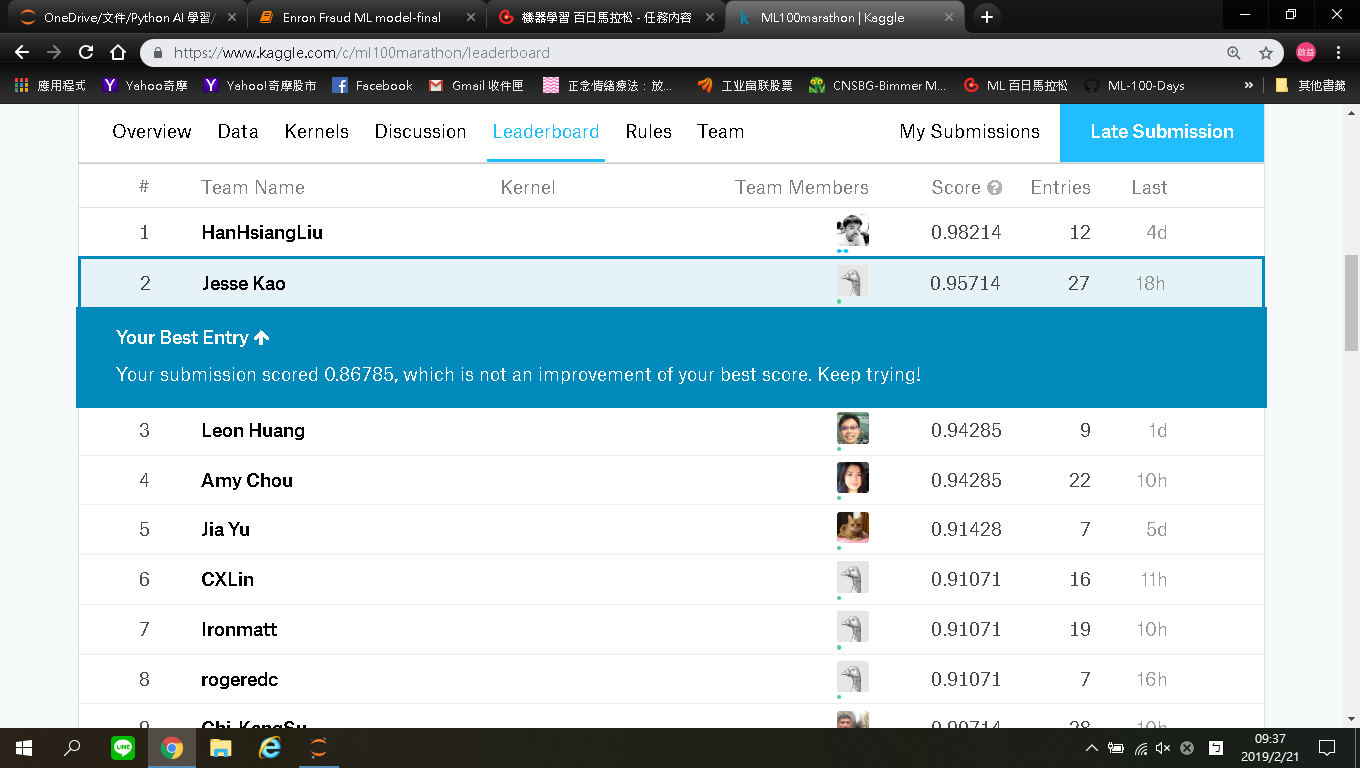